In [1]:
# importa bibliotecas a usar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
%matplotlib inline

In [2]:
# faz a leitura do ficheiro de dados localizado no github
url = 'https://raw.githubusercontent.com/dssg-pt/covid19pt-data/master/data.csv'
df = pd.read_csv(url,error_bad_lines=False)

In [3]:
# adiciona 2 colunas com o incremento diário
df['delta_confirmados'] = df['confirmados'].diff(1)
df['delta_obitos'] = df['obitos'].diff(1)

In [4]:
# drop das colunas desnecessárias
df.drop(df.iloc[:, 1:88], inplace = True, axis=1) 

In [5]:
# adiciona 1 coluna com o indice do serial interval para grouping
serial_interval_days = 4
df['serial_interval_idx'] = df.index // serial_interval_days

In [6]:
# calcula subtotais todos os n dias (grouping)

new_df = df.groupby('serial_interval_idx')['delta_confirmados'].sum()

# escreve ficheiro csv
#new_df.to_csv('serial_interval.csv')

# escreve livro Excel
#new_df.to_excel("covid-19-evolucao.xlsx",
#                sheet_name='Folha1')  


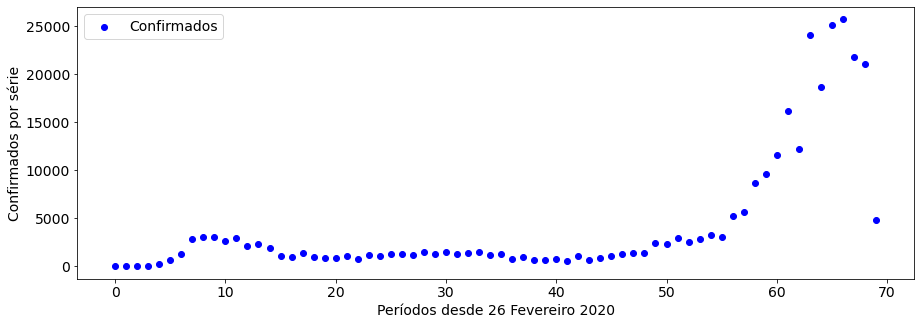

In [7]:
x = list(df.groupby('serial_interval_idx')['delta_confirmados'].sum().index)
y = list(df.groupby('serial_interval_idx')['delta_confirmados'].sum())


plt.rcParams['figure.figsize'] = [15, 5]
plt.rc('font', size=14)

# Real data
plt.scatter(x,y,label="Confirmados",color="blue")

plt.legend()
plt.xlabel("Períodos desde 26 Fevereiro 2020")
plt.ylabel("Confirmados por série")
plt.show()


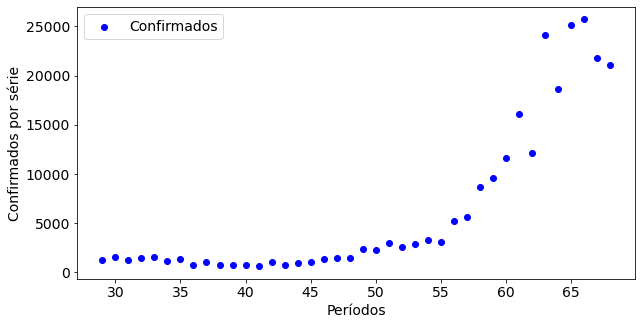

In [8]:
# Slicing do intervalo de tempo a analizar

numero_de_periodos = 40
periodo_final = max(df.index) // serial_interval_days
periodo_inicial = periodo_final - numero_de_periodos

x1 = x[periodo_inicial:periodo_final]
y1 = y[periodo_inicial:periodo_final]

plt.rcParams['figure.figsize'] = [10, 5]
plt.rc('font', size=14)

# Real data
plt.scatter(x1,y1,label="Confirmados",color="blue")

plt.legend()
plt.xlabel("Períodos")
plt.ylabel("Confirmados por série")

plt.show()


In [9]:
# define as funções utilizadas nos modelos

def idea_model(x,Rt,d):
    return np.power((Rt/(np.power((1+d),x))),x)
    

In [12]:
# utiliza curve_fit para fazer o ajuste dos dados, calculando os parâmetros R0, d

idea_fit = curve_fit(idea_model,x1,y1,p0=[1.1,0.010])


param_Rt = idea_fit[0][0]
param_d = idea_fit[0][1]

#param_Rt = 1.17
#param_d = 0.01

 
print("IDEA model: Rt = % 5.2f; d = % 5.2f" %(param_Rt, param_d))    


IDEA model: Rt =  1.22; d =  0.00


C:\Users\OMEN\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in power
  after removing the cwd from sys.path.


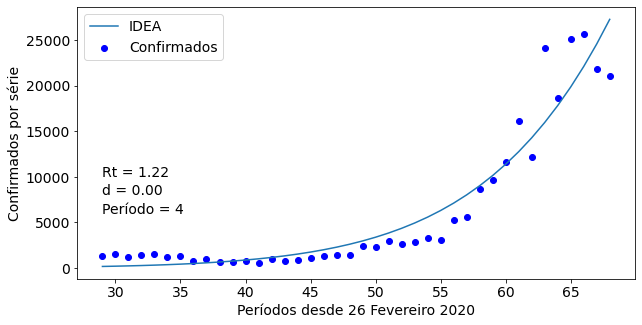

In [13]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.rc('font', size=14)

# Real data
plt.scatter(x1,y1,label="Confirmados",color="blue")
plt.plot(x1, [idea_model(i,param_Rt,param_d) for i in x1], label="IDEA" )

plt.legend()
plt.xlabel("Períodos desde 26 Fevereiro 2020")
plt.ylabel("Confirmados por série")
plt.annotate("Rt = "+str("{:.2f}".format(param_Rt)),xy=(periodo_inicial,10000))
plt.annotate("d = "+str("{:.2f}".format(param_d)),xy=(periodo_inicial,8000))
plt.annotate("Período = "+str(serial_interval_days),xy=(periodo_inicial,6000))
plt.show()


In [12]:
# falta qualidade do ajuste curve_fit